In [1]:
# 加载api_key等环境变量
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# 一、研究范围界定和研究简报生成

# prompt

In [2]:
# 提示词设计
# 目标：确认用户提供的任务是否清晰，如果不够清晰，则需要进一步让用户澄清
# [todo] 学习一下提示词的设计
from deep_research_from_scratch.utils import show_prompt
from deep_research_from_scratch.prompts import clarify_with_user_instructions

show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")


╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

In [3]:
from deep_research_from_scratch.prompts import transform_messages_into_research_topic_prompt

show_prompt(transform_messages_into_research_topic_prompt, "Transform messages into research brief")

╭──────────────────────────────────── Transform messages into research brief ─────────────────────────────────────╮
│                                                                                                                 │
│  You will be given a set of messages that have been exchanged so far between yourself and the user.             │
│  Your job is to translate these messages into a more detailed and concrete research question that will be used  │
│  to guide the research.                                                                                         │
│                                                                                                                 │
│  The messages that have been exchanged so far between yourself and the user are:                                │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  You will return a single research question that will be used to guide the research.                            │
│                                                                                                                 │
│  Guidelines:                                                                                                    │
│  1. Maximize Specificity and Detail                                                                             │
│  - Include all known user preferences and explicitly list key attributes or dimensions to consider.             │
│  - It is important that all details from the user are included in the instructions.                             │
│                                                                                                                 │
│  2. Handle Unstated Dimensions Carefully                                                                        │
│  - When research quality requires considering additional dimensions that the user hasn't specified,             │
│  acknowledge them as open considerations rather than assumed preferences.                                       │
│  - Example: Instead of assuming "budget-friendly options," say "consider all price ranges unless cost           │
│  constraints are specified."                                                                                    │
│  - Only mention dimensions that are genuinely necessary for comprehensive research in that domain.              │
│                                                                                                                 │
│  3. Avoid Unwarranted Assumptions                                                                               │
│  - Never invent specific user preferences, constraints, or requirements that weren't stated.                    │
│  - If the user hasn't provided a particular detail, explicitly note this lack of specification.                 │
│  - Guide the researcher to treat unspecified aspects as flexible rather than making assumptions.                │
│                                                                                                                 │
│  4. Distinguish Between Research Scope and User Preferences                                                     │
│  - Research scope: What topics/dimensions should be investigated (can be broader than user's explicit           │
│  mentions)                                            

# State and Schemas

- 使用writefile将代码写入文件，方便后续复用和部署

In [ ]:
%%writefile deep_research_from_scratch/state_scope.py

"""定义state和Pydantic的schema，用于后续的上下文传递。"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# ==== 定义state ====

class AgentInputState(MessagesState):
    """输入state，用于存储用户输入的指令和信息。"""
    pass

class AgentState(MessagesState):
    """用于多agent的上下文传递。"""

    # 研究简报，来自用户对话
    research_brief: Optional[str]
    # multi-agents的场景下，用于管理者(supervisor)和agent之间协调的信息传递
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # 原始的研究报告要点，来自研究阶段
    raw_notes: Annotated[list[str], operator.add] = []
    # 处理后的研究报告要点
    notes: Annotated[list[str], operator.add] = []
    # 最终的研究报告输出
    final_report: str

# ==== 结构后的输出schemas ====

class ClarifyWithUser(BaseModel):
    """schema用于确认用户输入的指令是否清晰。"""

    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """schema用于生成研究简报"""

    research_brief: str = Field(
        description="A research question that will be used to guide the research."
    )

Overwriting deep_research_from_scratch/state_scope.py


# Scope Research
- 研究范围界定

In [ ]:
%%writefile deep_research_from_scratch/research_agent_scope.py

"""
根据用户需求，生成研究简报。

该模块会创建”研究范围界定“的工作流，如下：
1. 判断用户需求是否清晰；
2. 根据对话，生成研究简报。
"""
import os
from dotenv import load_dotenv

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import (
    clarify_with_user_instructions,
    transform_messages_into_research_topic_prompt
)
from deep_research_from_scratch.state_scope import (
    AgentInputState,
    AgentState,
    ClarifyWithUser,
    ResearchQuestion
)

# ==== 工具函数 ====

def get_today_str() -> str:
    """获取当前日期字符串"""
    return datetime.now().strftime("%a %b %-d, %Y")

# ==== 配置 ====

# 加载环境变量
load_dotenv()

# 初始化gpt模型
api_url = os.getenv('KIMI_API_URL')
api_key = os.getenv('KIMI_API_KEY')
model_name = os.getenv('KIMI_MODEL')
model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    temperature=0.0,
    api_key=api_key,
    base_url=api_url
)

# ==== 工作流的结点 ====

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", END]]:
    """
    判断是否用户的请求信息包含足够的信息，用于生成研究简报。

    使用结构化的输出进行判断，同时避免幻觉。
    路由到研究简报生成，或生成一个需要用户澄清的问题。
    """
    # 结构化输出模型(相当于打开了模型的json_format开关，并转换为pydantic的schema)
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # 使用澄清用指令调用模型
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]),
            date=get_today_str()
        ))
    ])

    # 根据need_clarification，判断后续的流程，并更新state
    if response.need_clarification:
        return Command(
            goto=END,
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief",
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    """
    将会话内容转换为研究简报。

    使用结构化的输出，保证简报包含所有生成研究报告需要的细节和信息。
    """
    # 设置结构化输出模型
    structured_output_model = model.with_structured_output(ResearchQuestion)

    # 生成研究简报
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])

    # 更新state，生成研究简报并传递给管理者agent(supervisor)
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

# ==== 构建研究范围界定的工作流（基于langgraph） ====

# 创建工作流
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# 添加工作流的结点（nodes）
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

# 添加工作流的边（edges）
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# 编译工作流
scope_research = deep_researcher_builder.compile()

Overwriting deep_research_from_scratch/research_agent_scope.py


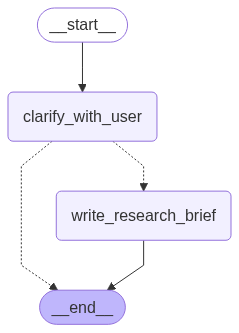

In [7]:
# 编译工作流，保存到内存，并绘制图
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph().draw_mermaid_png()))

In [8]:
# 运行工作流
from deep_research_from_scratch.utils import format_messages
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke(
    {"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco")]}, 
    config=thread
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To tailor the list to your preferences, could you clarify:                                                      │
│ - **Neighborhood focus** – any specific areas (e.g., Mission, SOMA, Richmond)?                                  │
│ - **Criteria** – are you most interested in:                                                                    │
│   1. Highest-rated specialty coffee / roasters                                                                  │
│   2. Best ambiance / workspace-friendly spots                                                                   │
│   3. Unique offerings (e.g., single-origin, experimental brewing methods)                                       │
│   4. Budget-friendly vs. premium                                                                                │
│ - **Visit purpose** – quick grab-and-go, sit-down meetings, or tourist exploration?                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
result = scope.invoke(
    {"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, 
    config=thread
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To tailor the list to your preferences, could you clarify:                                                      │
│ - **Neighborhood focus** – any specific areas (e.g., Mission, SOMA, Richmond)?                                  │
│ - **Criteria** – are you most interested in:                                                                    │
│   1. Highest-rated specialty coffee / roasters                                                                  │
│   2. Best ambiance / workspace-friendly spots                                                                   │
│   3. Unique offerings (e.g., single-origin, experimental brewing methods)                                       │
│   4. Budget-friendly vs. premium                                                                                │
│ - **Visit purpose** – quick grab-and-go, sit-down meetings, or tourist exploration?                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Understood. You want to focus on **coffee quality** to identify the best coffee shops in San Francisco, without │
│ restricting the search to any specific neighborhood, ambiance, or visit purpose. I will now research and        │
│ compile a list of the top-rated specialty coffee shops and roasters city-wide, prioritizing those recognized    │
│ for exceptional beans, expert brewing techniques, and consistent quality.                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

I want to identify the best coffee shops in San Francisco when judged strictly by coffee quality. Please compile a 
ranked short-list (10–15 venues) that excels in the following quality dimensions: (1) bean sourcing transparency   
and freshness (roast date, farm/estate details, direct-trade or equivalent relationships), (2) roasting skill and  
consistency (in-house or partner roaster reputation, roast-level precision, awards or competition placements), (3) 
brewing technique and equipment (espresso extraction parameters, filter methods such as pour-over, siphon, or cold 
brew, barista training/certifications), and (4) sensory evaluation (recent professional cupping scores, Q-grader or
certified taster reviews, and any documented blind-tasting accolades). Include only specialty coffee shops or      
roaster-cafés that are physically located within the city limits of San Francisco; no neighborhood restrictions    
have been specified. For each venue, provide: official website link, address, primary roaster (if different from   
café), flagship beans or seasonal offerings, and concise evidence of quality (e.g., 2024 Good Food Award, 93-point 
Coffee Review score, US Brewers Cup finalist). If price ranges, ambiance, seating, or dietary options have not been
specified by me, treat them as non-filtering factors—include all price tiers and formats unless they directly      
impede coffee quality. Prioritize information from official roaster/café websites, competition results published by
SCA or US Coffee Championships, and direct links to Coffee Review or similar professional evaluations; avoid       
relying solely on Yelp or general blog round-ups.

- 可以在langsmith上查看调用过程

# 二、效果评估
评估生成的研究简报的质量，从以下两个角度：
  - 它从用户聊天中捕捉相关标准
  - 它不会发明或假设用户没有明确提供的任何标准

# 数据集
下面提供了两个会话示例：

In [11]:
from langchain_core.messages import AIMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $50,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $50,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in NYC, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in NYC."),
    HumanMessage(content="I'd prefer to live in Chelsea, Flatiron, or West Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 7k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in September 2025."),
]

人工地将上述会话中的用户要求（标准）进行总结：

In [12]:
criteria_1 = [
    "Current age is 25",
    "Desired retirement age is 45",
    "Current risk tolerance is high",
    "Interested in investing in stocks and ETFs",
    "Open to forms of investment beyond stocks and ETFs"
    "Investment account is a regular brokerage account",
]

criteria_2 = [
    "Looking for a 2 bed 2 bath apartment in Chelsea, Flatiron, or West Village",
    "Monthly rent below 7k",
    "Should be in a doorman building",
    "Ideally have an in unit washer and dryer but not strict",
    "Ideally have a gym but not strict",
    "Move in date is September 2025"
]

In [13]:
import os
from langsmith import Client

# 初始化langsmith client
langsmith_client = Client(api_key=os.getenv("LANGCHAIN_API_KEY"))

# 创建数据集
dataset_name = "deep_research_scoping"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
    # 构建数据集
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that measures the quality of research briefs generated from an input conversation",
    )

    # 添加示例
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"messages": conversation_1},
                "outputs": {"criteria": criteria_1},
            },
            {
                "inputs": {"messages": conversation_2},
                "outputs": {"criteria": criteria_2},
            },
        ],
    )

# 评估器1: 提示词
- 它从用户聊天中捕捉相关标准

In [14]:
from deep_research_from_scratch.prompts import BRIEF_CRITERIA_PROMPT

show_prompt(BRIEF_CRITERIA_PROMPT, "BRIEF_CRITERIA_PROMPT")

╭───────────────────────────────────────────── BRIEF_CRITERIA_PROMPT ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are an expert research brief evaluator specializing in assessing whether generated research briefs         │
│  accurately capture user-specified criteria without loss of important details.                                  │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief adequately captures the specific success criterion provided. Return a binary   │
│  assessment with detailed reasoning.                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs are critical for guiding downstream research agents. Missing or inadequately captured          │
│  criteria can lead to incomplete research that fails to address user needs. Accurate evaluation ensures         │
│  research quality and user satisfaction.                                                                        │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <criterion_to_evaluate>                                                                                        │
│  {criterion}                                                                                                    │
│  </criterion_to_evaluate>                                                                                       │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  CAPTURED (criterion is adequately represented) if:                                                             │
│  - The research brief explicitly mentions or directly addresses the criterion                                   │
│  - The brief contains equivalent language or concepts that clearly cover the criterion                          │
│  - The criterion's intent is preserved even if worded differently                                               │
│  - All key aspects of the criterion are represented in the brief                                                │
│                                                                                                                 │
│  NOT CAPTURED (criterion is missing or inadequately ad

# 评估器1

In [16]:
from typing_extensions import cast
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class Criteria(BaseModel):
    """
    单个标准的评估结果。
    """
    # 待评估的标准
    criteria_text: str = Field(
        description="The specific success criteria being evaluated (e.g., 'Current age is 25)', 'Monthly rent below 7k'",
    )
    # 评估理由
    reasoning: str = Field(
        description="Detailed explanation of why this criteria is or isn't captured in the research brief, including specific evidence from the brief"
    )
    # 是否在研究简报中被提及（捕获），True or False
    is_captured: bool = Field(
        description="Whether this specific criteria is adequately captured in the research brief (True) or missing/inadequately addressed (False)"
    )

def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    """
    评估研究简报中是否捕获了所有用户要求的标准。

    Args:
        outputs: 研究简报
        reference_outputs: 用户要求的标准

    Returns:
        Dict: 单个标准的评估结果打分(0.0-1.0)
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]
    
    # 初始化模型
    api_url = os.getenv('KIMI_API_URL')
    api_key = os.getenv('KIMI_API_KEY')
    model_name = os.getenv('KIMI_MODEL')
    model = ChatOpenAI(
        model=model_name, 
        temperature=0.0,
        api_key=api_key,
        base_url=api_url,
    )
    structured_output_model = model.with_structured_output(Criteria)

    # 评估每个标准(LLM-as-a-judge)
    responses = structured_output_model.batch([
        [
            HumanMessage(
                content=BRIEF_CRITERIA_PROMPT.format(
                    research_brief=research_brief,
                    criterion=criterion
                )
            )
        ]
        for criterion in success_criteria
    ])

    # 确保criteria_text正确填充
    individual_evaluations = [
        Criteria(
            reasoning=response.reasoning,
            criteria_text=criterion,
            is_captured=response.is_captured
        )
        for criterion, response in zip(success_criteria, responses)
    ]

    # 计算总分
    captured_count = sum(1 for eval_result in individual_evaluations if eval_result.is_captured)
    total_count = len(individual_evaluations)

    return {
        "key": "success_criteria_score",
        "score": captured_count / total_count if total_count > 0 else 0.0,
        "individual_evaluations": [
            {
                "criteria": eval_result.criteria_text,
                "captured": eval_result.is_captured,
                "reasoning": eval_result.reasoning
            }
            for eval_result in individual_evaluations
        ]
    }

# 评估器2: 提示器
- 它不会发明或假设用户没有明确提供的任何标准

In [15]:
from deep_research_from_scratch.prompts import BRIEF_HALLUCINATION_PROMPT

show_prompt(BRIEF_HALLUCINATION_PROMPT, "BRIEF_HALLUCINATION_PROMPT")

╭────────────────────────────────────────── BRIEF_HALLUCINATION_PROMPT ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  ## Brief Hallucination Evaluator                                                                               │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are a meticulous research brief auditor specializing in identifying unwarranted assumptions that could     │
│  mislead research efforts.                                                                                      │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief makes assumptions beyond what the user explicitly provided. Return a binary    │
│  pass/fail judgment.                                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs should only include requirements, preferences, and constraints that users explicitly stated    │
│  or clearly implied. Adding assumptions can lead to research that misses the user's actual needs.               │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <success_criteria>                                                                                             │
│  {success_criteria}                                                                                             │
│  </success_criteria>                                                                                            │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  PASS (no unwarranted assumptions) if:                                                                          │
│  - Brief only includes explicitly stated user requirements                                                      │
│  - Any inferences are clearly marked as such or logically necessary                                             │
│  - Source suggestions are general recommendations, not specific assumptions                                     │
│  - Brief stays within the scope of what the user actually requested                                             │
│                                                       

# 评估器2

In [17]:
class NoAssumptions(BaseModel):
    """
    评估结果，研究简报是否包含幻觉。
    """
    no_assumptions: bool = Field(
        description="Whether the research brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated."
    )
    reasoning: str = Field(
        description="Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements."
    )

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    """
    评估研究简报是否假设了用户没有明确提供的任何标准。
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]

    # 初始化模型
    api_url = os.getenv('KIMI_API_URL')
    api_key = os.getenv('KIMI_API_KEY')
    model_name = os.getenv('KIMI_MODEL')
    model = ChatOpenAI(
        model=model_name, 
        temperature=0.0,
        api_key=api_key,
        base_url=api_url,
    )
    structured_output_model = model.with_structured_output(NoAssumptions)

    response = structured_output_model.invoke([
        HumanMessage(content=BRIEF_HALLUCINATION_PROMPT.format(
            research_brief=research_brief,
            success_criteria=str(success_criteria)
        ))
    ])

    return {
        "key": "no_assumptions_score",
        "score": response.no_assumptions,
        "reasoning": response.reasoning
    }

# 进行评估

In [18]:
import uuid

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return scope.invoke(inputs, config=config)

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    experiment_prefix="Deep Research Scoping"
)

View the evaluation results for experiment: 'Deep Research Scoping-cfc8faa5' at:
https://smith.langchain.com/o/eb8bebb5-7e5c-489b-8a33-b1f12a101f70/datasets/cdf6c353-3e82-4346-ab2c-920319967568/compare?selectedSessions=9fbe4027-3a83-4bd9-927f-896edcdf0282




0it [00:00, ?it/s]

<ExperimentResults Deep Research Scoping-cfc8faa5>